# Basic ML experimentation

In [201]:

%load_ext autoreload
%autoreload 2

import datetime as dt
import pandas as pd
import numpy as np
from market_analysis.dataset import get_stock_data
from market_analysis.features import get_Nday_return
from loguru import logger
from xgboost import XGBClassifier
import talib.abstract as ta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

logger.disable("market_analysis")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
indicator_strings = [  # Momentum
    "ADX",
    "ADXR",
    "APO",
    "AROON",
    "AROONOSC",
    "BOP",
    "CCI",
    "CMO",
    "DX",
    "MACD",
    "MACDEXT",
    "MACDFIX",
    "MFI",
    "MINUS_DI",
    "MINUS_DM",
    "MOM",
    "PLUS_DI",
    "PLUS_DM",
    "PPO",
    "ROC",
    "ROCP",
    "ROCR",
    "ROCR100",
    "RSI",
    "STOCH",
    "STOCHF",
    "STOCHRSI",
    "TRIX",
    "ULTOSC",
    "WILLR",
    # Volatility
    "ATR",
    "NATR",
    "TRANGE",
    # Volume
    "ADOSC",
]

In [340]:
df = get_stock_data("AZN.L", end_date=(2024, 12, 6), days=365.25 * 12)

[*********************100%***********************]  1 of 1 completed


In [411]:
def format_data(df):

    feature_names = []

    for indicator_string in indicator_strings:
        indicators = ta.Function(indicator_string)(df)

        if isinstance(indicators, pd.DataFrame):

            # Rename columns to avoid duplicated names
            for indicator_name in indicators.columns:
                indicators.rename(
                    columns={indicator_name: f"{indicator_string}_{indicator_name}"}, inplace=True
                )

            feature_names.extend(indicators.columns)
            df = pd.concat([df, indicators], axis=1)
        else:

            feature_names.append(indicator_string)
            df[indicator_string] = indicators

    df["RTN_D-1"] = get_Nday_return(df, days=1, log=False, append_column=False, shift=True)
    df["Y_TRUE"] = df["RTN_D-1"].map(lambda x: 1 if x > 0 else 0)  # Prediction variable
    df["ABS_RTN_D-1"] = abs(df["RTN_D-1"])  # Can be used as weight

    df_clean = df.dropna().copy(deep=True)  # Drop NANs

    # Rescale feature variables
    scaler = MinMaxScaler()
    scaler.set_output(transform="pandas")
    df_transformed = scaler.fit_transform(df_clean[feature_names])

    df_clean[feature_names] = df_transformed[feature_names]

    feature_names

    return df_clean, feature_names, "Y_TRUE", "ABS_RTN_D-1"

In [412]:
data, feature_names, target_name, weight_name = format_data(df)

In [413]:
from sklearn import metrics
import matplotlib.pyplot as plt

classifier_dict = {"name": "factor_investing", "features": feature_names, "classifiers": []}

results = {}

for i, (train_index, test_index) in enumerate(TimeSeriesSplit(n_splits=4, gap=30).split(data)):


    train_x = data[feature_names].iloc[train_index]
    train_y = data[target_name].iloc[train_index]
    train_w = data[weight_name].iloc[train_index]

    test_x = data[feature_names].iloc[test_index]
    test_y = data[target_name].iloc[test_index]
    test_w = data[weight_name].iloc[test_index]

    BDT = XGBClassifier(colsample_bytree=8/len(feature_names))

    BDT.set_params(eval_metric=["logloss", "auc"])
    BDT.fit(
        X=train_x,
        y=train_y,
        sample_weight=train_w,
        verbose=True,
        eval_set=[(test_x, test_y)],
        sample_weight_eval_set=[test_w],
    )

    results[i] = {"y_target": test_y, 
                  "y_pred": BDT.predict_proba(test_x)[:, 1], 
                  "w": test_w}

[0]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[1]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[2]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[3]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[4]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[5]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[6]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[7]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[8]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[9]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[10]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[11]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[12]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[13]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[14]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[15]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[16]	validation_0-logloss:0.69284	validation_0-auc:0.50000
[17]	va

date
2015-08-17    0.007480
2015-08-18    0.016241
2015-08-19    0.012854
2015-08-20    0.031418
2015-08-21    0.037124
                ...   
2017-12-04    0.004847
2017-12-05    0.000318
2017-12-06    0.003917
2017-12-07    0.016791
2017-12-08    0.019440
Name: ABS_RTN_D-1, Length: 588, dtype: float64
date
2017-12-11    0.011893
2017-12-12    0.004357
2017-12-13    0.005902
2017-12-14    0.000717
2017-12-15    0.006249
                ...   
2020-04-01    0.017178
2020-04-02    0.023496
2020-04-03    0.005599
2020-04-06    0.025612
2020-04-07    0.004143
Name: ABS_RTN_D-1, Length: 588, dtype: float64
date
2020-04-08    0.021518
2020-04-09    0.068108
2020-04-14    0.001183
2020-04-15    0.026658
2020-04-16    0.019442
                ...   
2022-08-02    0.010946
2022-08-03    0.005440
2022-08-04    0.013619
2022-08-05    0.013989
2022-08-08    0.011947
Name: ABS_RTN_D-1, Length: 588, dtype: float64
date
2022-08-09    0.002214
2022-08-10    0.028841
2022-08-11    0.019608
2022-08-12 

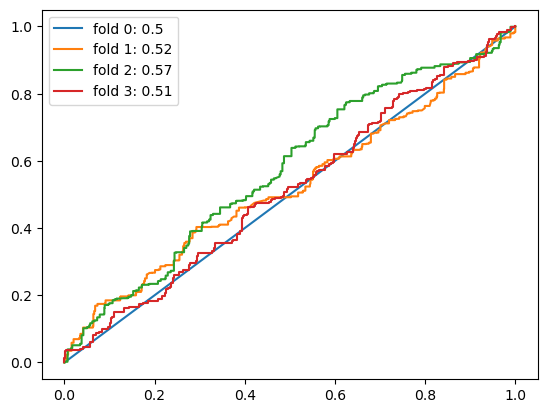

In [414]:
fig = plt.figure()

for key in results.keys():
    
    # if key !=0:
    #     break
    
    print(results[key]["w"])
        
    fpr, tpr, thresholds = metrics.roc_curve(
        results[key]["y_target"], 
        results[key]["y_pred"], 
        sample_weight=results[key]["w"])
    
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"fold {key}: " + str(round(roc_auc, 2)))
    
plt.legend()

In [367]:
results[3]['y_target']

date
2022-08-09    0
2022-08-10    0
2022-08-11    1
2022-08-12    1
2022-08-15    1
             ..
2024-11-28    1
2024-11-29    0
2024-12-02    1
2024-12-03    0
2024-12-04    1
Name: Y_TRUE, Length: 588, dtype: int64